<h3 style="margin-bottom: 1em;"><img src="https://www.proteinmetrics.com/wp-content/uploads/2017/08/logo.svg" width="320" style="display: inline; margin: 0 2em 0 0;" /> Non-Continuous Convolution</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.stats
import matplotlib

In [2]:
# global settings and variables
%precision 6
pd.set_option('display.float_format', lambda x: '%.6f' % x)
np.set_printoptions(suppress=True)
matplotlib.rcParams['figure.figsize'] = (16.0, 5.0)

In [97]:
# %%writefile utils.py
# %load utils.py

# https://stackoverflow.com/questions/29156532/python-baseline-correction-library
def baseline_als(y, lam=100, p=0.01, niter=10):
    L = len(y)
    diag = np.ones(L - 2)
    D = scipy.sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L-2).tocsc()
    w = np.ones(L)
    for i in range(niter):
        W = scipy.sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = scipy.sparse.linalg.spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z


def set_xlim_and_correct_ylim(ax, lbound, ubound, x, y):
    ax.set_xlim(lbound, ubound)
    lims = ax.get_xlim()
    idx  = np.where((x > lims[0]) & (x < lims[1]))[0]
    ax.set_ylim(y[idx].min(), y[idx].max() * 1.05) 


def setup_toggable_legend_lines(legend, fig, ax_lines):
    lined = dict()
    for legline, origline in zip(legend.get_lines(), ax_lines):
        origline = origline if hasattr(origline, '__iter__') else [origline]
        legline.set_picker(5)  # 5 pts tolerance
        lined[legline] = origline

    def _onpick(event):
        legline  = event.artist
        origline = lined[legline]
        visible  = not origline[0].get_visible()
        [l.set_visible(visible) for l in origline]
        legline.set_alpha(1.0 if visible else 0.2)
        # fig.canvas.draw()
        display('onpick')

    fig.canvas.mpl_connect('pick_event', _onpick)
    return lined


def plot_lines_and_peaks(*series):
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    lines   = [ax.plot(data['x'],      data['y'], label=data['label']) for data in series if data['type'] == 'line']
    peaks   = [ax.vlines(data['x'], 0, data['y'], label=data['label']) for data in series if data['type'] == 'peaks']
    legend  = plt.legend(loc='upper right')
    setup_toggable_legend_lines(legend, fig, lines + peaks)
    plt.subplots_adjust(left=0, right=0.99)
    plt.show()


def toggle_line(ax, idx):
    ax.lines[idx].set_visible(not ax.lines[idx].get_visible())
    
    
def toggle_collection(ax, idx):
    ax.collections[idx].set_visible(not ax.collections[idx].get_visible())

In [7]:
# %load io.py

def read_mzml_file(filename, mslevel=None, verbose=False):
    from pyteomics import mzml
    
    def _parse_scan(index, scan):
        return {
            'index':    index,
            'id':       scan['index'],
            'rt':       float(scan['scanList']['scan'][0]['scan start time']),
            'number':   scan['index'],
            'nativeId': scan['id'],
            'mz':       scan['m/z array'],
            'intens':   scan['intensity array']
        }
    
    spectra = mzml.read(filename, use_index=True)
    spectra = [
        _parse_scan(index, scan)
        for index, scan in enumerate(spectra)
        if mslevel is None or scan.get('ms level') == mslevel
    ]
    if verbose:
        display('# scans', len(spectra))
        display('sample spectra: {}'.format(spectra[len(spectra // 2)]))
        
    return spectra
        

def read_byspec2_file(filename, offset=None, limit=None, mslevel=None, verbose=False):
    import sqlite3
    def _parse_sqlite_results(results):
        return [{
            'index':    index,
            'id':       row[0],
            'rt':       row[1],
            'number':   row[2],
            'nativeId': row[3],
            'mz':       np.frombuffer(row[4], dtype=np.float64),
            'intens':   np.frombuffer(row[5], dtype=np.float32)
        } for index, row in enumerate(results)]
    
    limit_filter = f' LIMIT {offset},{limit}' if offset and limit else ''
    level_filter = f' AND (s.MSLevel = {mslevel})' if mslevel else ''
    
    connection   = sqlite3.connect(filename)
    query        = 'SELECT s.Id, s.RetentionTime, s.ScanNumber, s.NativeId, p.PeaksMz, p.PeaksIntensity ' + \
                   'FROM Spectra AS s JOIN Peaks AS p ON (s.PeaksId = p.Id)' + \
                  f'WHERE (p.PeaksCount > 0){level_filter}{limit_filter}'
    if verbose:
        display(f'INFO | full query: {query}')
    
    parsed_scans = _parse_sqlite_results(connection.execute(query).fetchall())
    connection.close()
    return parsed_scans


def printnp(arr):
    return ', '.join(map(lambda x: '{:.4f}'.format(x), arr))


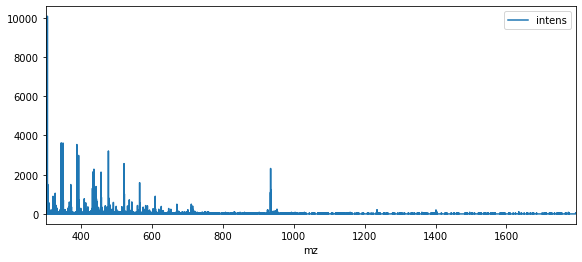

In [9]:
all_scans = {}
filename  = 'E:\\Mass Spectra\\MAM\\6544\\Converted\\6544.REF_MSMS.byspec2'
scans     = all_scans[filename] = read_byspec2_file(filename, mslevel=1, offset=3000, limit=100)
scan      = np.random.choice(scans)
mzs       = scan['mz']
intenss   = scan['intens']
df        = pd.DataFrame({'mz': mzs, 'intens': intenss})
# df.describe()

df.plot(x='mz', y='intens', figsize=(9.5, 4));

In [ ]:
filename = 'E:\\Mass Spectra\\MAM\\1448\\Converted\\1448.REF_MSMS.byspec2'
scans    = all_scans[filename] = read_byspec2_file(filename, mslevel=1, offset=1000, limit=100)
scan     = np.random.choice(scans)
mzs      = scan['mz']
intenss  = scan['intens']
df = pd.DataFrame({'mz': mzs, 'intens': intenss})
# df.describe()
df.plot(x='mz', y='intens', figsize=(16, 4));

In [34]:
def convolve(mzs, intenss, sigma=0.01):
    max_mz_win = sigma * 3
    max_mz_idx = 20  # 100

    # convert mz-deltas to convolution window indexes
    window_mult   = window.size / (2 * max_mz_win)
    window_offset = window.size // 2
    def conv_window(mz_deltas, intenss):
        indexes = (mz_deltas * window_mult).astype(np.int32) + window_offset
        # display(f'mz deltas: {mz_deltas}')
        # display(f'indexes: {indexes}')
        return np.dot(window[indexes], intenss)

    convolved  = np.empty(mzs.shape, dtype=np.float64)
    for i, mz in enumerate(mzs):
        low_diffs    = mzs[max(0, i - max_mz_idx):i] - mz
        up_diffs     = mzs[i:i + max_mz_idx] - mz
        low_intens   = intenss[max(0, i - max_mz_idx):i + 1]
        up_intens    = intenss[i:i + max_mz_idx]
        low_idxs     = np.where(low_diffs > -max_mz_win)[0]
        up_idxs      = np.where(up_diffs  <  max_mz_win)[0]
        conv_diffs   = np.concatenate([low_diffs[low_idxs],  np.array([0]),  up_diffs[up_idxs]])
        conv_intens  = np.concatenate([low_intens[low_idxs], intenss[i:i+1], up_intens[up_idxs]])
        convolved[i] = conv_window(conv_diffs, conv_intens)
        #if mz > 406.8 and mz < 407.1:
        #    # display(f'mz:         {mz}')
        #    # display(f'max_mz_win: {max_mz_win}')
        #    # display(f'low_intens: {low_intens}')
        #    # display(f'up_intens:  {up_intens}')
        #    # display(f'low_diffs:  {low_diffs}')
        #    # display(f'low_idxs:   {low_idxs}')
        #    # display(f'up_idxs:    {up_idxs}')
        #    # display(f'conv_diffs:  {conv_diffs}')
        #    # display(f'conv_intens: {conv_intens}')
        #    display(f'mz: {mz}; convolved: {convolved[i]}')
        #    # display(f'---------------------------------------')
    return convolved


def local_maxima(signal):
    return np.where(np.r_[True, signal[1:] > signal[:-1]] &
                    np.r_[signal[:-1] > signal[1:], True])[0]

In [99]:
# %%writefile uniform_grid.py
# %load uniform_grid.py

def convert_to_uniform_grid(scan, resolution=1000, method='linear'):
    mzS    = np.floor(scan['mz'][0])
    mzE    = np.ceil(scan['mz'][-1])
    grid   = np.linspace(mzS, mzE, int((mzE - mzS) * resolution), dtype=np.float32)
    interp = scipy.interpolate.griddata(scan['mz'].astype(np.float32), scan['intens'].astype(np.float32),
                                        grid, fill_value=0.0, method=method)
    return grid, interp


def convolve_gaussian_uniform_grid(signal, sigma=0.01, resolution=1000, std=1.0, mode='same', plot=False):
    convwin   = sig.windows.gaussian(M=int(sigma * 6 * resolution), std=sigma * resolution)
    # convwin = sig.windows.hann(M=int(sigma * 6 * resolution))
    convwin  /= convwin.sum()
    convolved = np.convolve(signal, convwin, mode=mode)

    if plot:
        # %matplotlib inline
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.plot(signal,    label='Signal')
        ax.plot(convolved, label='Convolved')
        ax.set_title('Gaussian Convolution');
        ax.legend()
        
    return convolved


def local_maxima_uniform_grid(signal, mz_grid, intens_grid, plot=False):
    idxs = local_maxima(signal)

    if plot:
        # %matplotlib inline
        fig, ax = plt.subplots(figsize=(16, 5))
        ax.vlines(mz_grid[idxs], 0, intens_grid[idxs], 'b')
        ax.set_title('Local Max Peaks');
    
    return mz_grid[idxs], intens_grid[idxs], idxs


def build_isotope_window(charge, resolution=1000, win_num_isotopes=5, isotope_perc_width=0.01):
    base_mz_delta    = 1.0031
    isotope_delta    = base_mz_delta / charge
    isotope_width    = isotope_delta * isotope_perc_width
    win_size         = int(round((((win_num_isotopes - 1) * isotope_delta) + isotope_width) * resolution))
    isotope_window   = np.zeros(win_size)
    for i in range(win_num_isotopes):
        lbound = int(round((i * isotope_delta) * resolution))
        ubound = int(round((i * isotope_delta + isotope_width) * resolution))
        isotope_window[lbound:ubound].fill(1.0)
        
    isotope_window /= isotope_window.sum()
    return isotope_window
        
    
def apply_peak_isotope_score(local_max_idxs, local_max_intens, mz_grid, weight=5.0, plot=False):
    grid = np.zeros(mz_grid.shape)
    grid[local_max_idxs] = local_max_intens
    convolved_list = [np.convolve(grid, window, mode='same') for window in ISOTOPE_WINDOWS]
    convolved_max  = np.amax(np.vstack(convolved_list), axis=0)
    scored_intens  = local_max_intens + (convolved_max[local_max_idxs] * weight)

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(20, 6))
        l1  = ax.vlines(mz_grid[local_max_idxs], 0, scored_intens,    'r', label='Local Max + Iso. Score')
        l2  = ax.vlines(mz_grid[local_max_idxs], 0, local_max_intens, 'b', label='Local Max')
        leg = plt.legend()
        setup_toggable_legend_lines(leg, fig, [l1, l2])
        plt.subplots_adjust(left=0, right=0.999)
        plt.show()
        
    return scored_intens


def prune_with_gradient(local_max_mzs, local_max_intens, local_max_idxs, gradient_threshold=0.01, plot=False):
    sorted_intenss  = np.sort(local_max_intens)[::-1]
    gradient        = np.gradient(sorted_intenss)
    smooth_gradient = sig.medfilt(gradient, kernel_size=11)
    cutoff_index    = np.where(smooth_gradient > -gradient_threshold)[0][0]
    cutoff_intens   = sorted_intenss[cutoff_index]
    threshold_idxs  = np.where(local_max_intens > cutoff_intens)[0]
    pruned_idxs     = local_max_idxs[threshold_idxs]
    pruned_mzs      = local_max_mzs[threshold_idxs]
    pruned_intens   = local_max_intens[threshold_idxs]
    display(f'Prune With Gradient | original local max peaks: {len(local_max_intens)}; after pruning: {len(pruned_intens)}')

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(16, 4))
        ax[0].plot(sorted_intenss,  label='Ranked Intensities')
        ax[1].plot(gradient,        label='Gradient')
        ax[1].plot(smooth_gradient, label='Smooth Gradient')
        plt.legend()
        plt.show()

    return pruned_mzs, pruned_intens, pruned_idxs


def convolve_with_downsampling(local_max_mzs, local_max_intens, mz_grid, window, subsample_ratio=100, plot=False):
    def _subsample_average(arr, n):
        end =  n * int(len(arr)/n)
        return np.mean(arr[:end].reshape(-1, n), 1)
    
    grid = np.copy(mz_grid)
    local_max_interpolated = scipy.interpolate.griddata(local_max_mzs, local_max_intens, mz_grid, fill_value=0.0, method='nearest')
    local_max_subsampled   = _subsample_average(local_max_interpolated, subsample_ratio)
    convolved              = np.convolve(local_max_subsampled, window / window.sum(), mode='same')
    convolved_upsampled    = scipy.interpolate.griddata(grid[::subsample_ratio], convolved, grid, method='linear')

    if plot:
        plt.plot(mz_grid, convolved_upsampled, 'y', label='Centroid Convolved')
        plt.vlines(lmax_mzs, 0, np.log(lmax_intens), 'b', label='Centroid')

    return convolved_upsampled


def prune_with_convolution(local_max_mzs, local_max_intens, local_max_idxs, mz_grid, intens_grid,
                           window=scipy.signal.windows.cosine(M=201), plot=False):
    threshold_signal = convolve_with_downsampling(local_max_mzs, local_max_intens, mz_grid, window)
    threshold_idxs   = np.where(local_max_intens > threshold_signal[local_max_idxs])[0]
    pruned_idxs      = local_max_idxs[threshold_idxs]
    pruned_mzs       = local_max_mzs[threshold_idxs]
    pruned_intens    = local_max_intens[threshold_idxs]
    display(f'Prune With Convolution | original local max peaks: {len(local_max_intens)}; after pruning: {len(pruned_intens)}')

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(16, 5))
        l0  = ax.plot(mz_grid, intens_grid,                      label='Profile')
        l1  = ax.plot(mz_grid, threshold_signal,                 label='Threshold')
        l2  = ax.vlines(local_max_mzs, 0, local_max_intens, 'y', label='Local Max. Peaks')
        l3  = ax.vlines(pruned_mzs,    0, pruned_intens,    'b', label='Local Max. Peaks Filtered')
        leg = plt.legend(loc='upper right')
        setup_toggable_legend_lines(leg, fig, [l0, l1, l2, l3])
        plt.subplots_adjust(left=0, right=0.999)
        plt.show()

    return pruned_mzs, pruned_intens, pruned_idxs


ISOTOPE_WINDOWS = [build_isotope_window(charge, isotope_perc_width=0.01) for charge in range(1, 6)]

### Convolution on "uniform grid" interpolated profile data

In [ ]:
%matplotlib nbagg
sigma = 0.01   # 0.07281
scan  = np.random.choice(scans)

mz_grid, intens_grid = convert_to_uniform_grid(scan)
convolved = convolve_gaussian_uniform_grid(intens_grid, sigma, plot=True)

lmax_mzs,      lmax_intens,      lmax_idxs      = local_maxima_uniform_grid(convolved, mz_grid, intens_grid)
pruneconv_mzs, pruneconv_intens, pruneconv_idxs = prune_with_convolution(lmax_mzs, lmax_intens, lmax_idxs, mz_grid, intens_grid)
prunegrad_mzs, prunegrad_intens, prunegrad_idxs = prune_with_gradient(lmax_mzs, lmax_intens, lmax_idxs)

# --- add isotope scoring
isotope_scored_intens = apply_peak_isotope_score(lmax_idxs, lmax_intens, mz_grid)
pruneconv_scored_mzs, pruneconv_scored_intens, pruneconv_scored_idxs = prune_with_convolution(lmax_mzs, isotope_scored_intens, lmax_idxs, mz_grid, intens_grid)
prunegrad_scored_mzs, prunegrad_scored_intens, prunegrad_scored_idxs = prune_with_gradient(lmax_mzs, isotope_scored_intens, lmax_idxs)

<IPython.core.display.Javascript object>


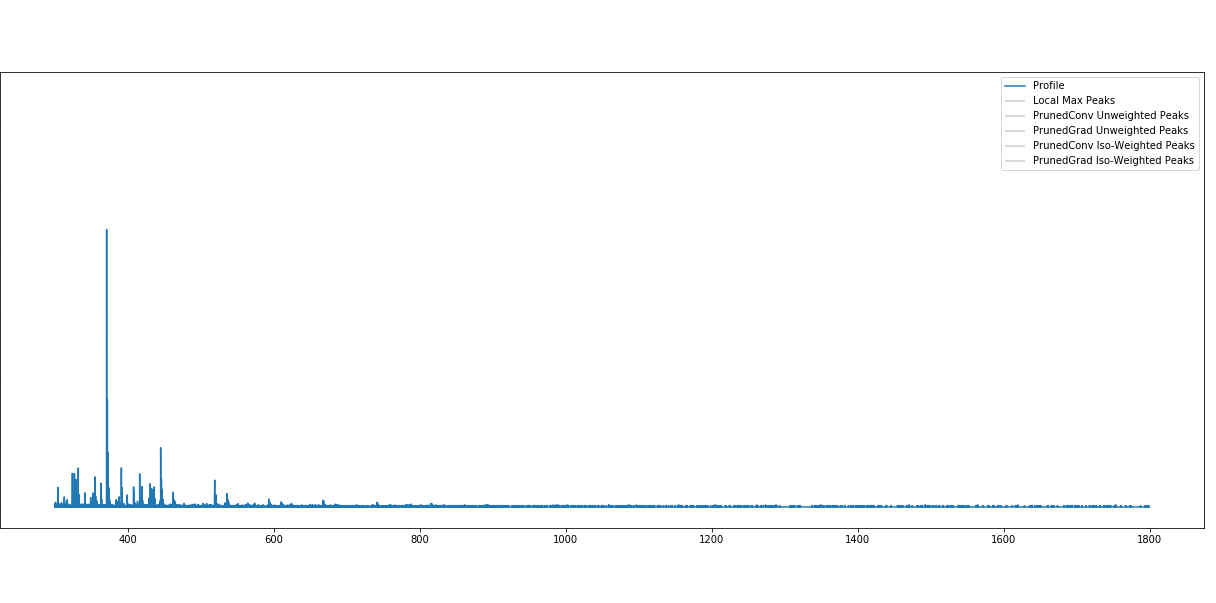

In [94]:
plot_lines_and_peaks(
    {'type': 'line',  'x': mz_grid,              'y': intens_grid,             'label': 'Profile'},
    {'type': 'peaks', 'x': lmax_mzs,             'y': lmax_intens,             'label': 'Local Max Peaks'},
    {'type': 'peaks', 'x': pruneconv_mzs,        'y': pruneconv_intens,        'label': 'PrunedConv Unweighted Peaks'},
    {'type': 'peaks', 'x': prunegrad_mzs,        'y': prunegrad_intens,        'label': 'PrunedGrad Unweighted Peaks'},
    {'type': 'peaks', 'x': pruneconv_scored_mzs, 'y': pruneconv_scored_intens, 'label': 'PrunedConv Iso-Weighted Peaks'},
    {'type': 'peaks', 'x': prunegrad_scored_mzs, 'y': prunegrad_scored_intens, 'label': 'PrunedGrad Iso-Weighted Peaks'}
)

In [181]:
# ---- benchmarks ---- 
# scan
# x = scan['mz'].astype(np.float16)
# y = scan['intens'].astype(np.float16)
# %timeit scipy.interpolate.griddata(x, y, grid, fill_value=0.0, method='nearest')
# %timeit np.convolve(interp, filtwin, mode='same')
# %time sig.convolve(interp, filtwin, mode='same', method='direct')
# %time convolve(mzs, intenss, sigma=sigma)